In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt


In [4]:
#Load the Kaggle dataset
df = pd.read_csv("breast-cancer.csv")  
df = df.drop(columns=["id", "Unnamed: 32"], errors='ignore')  
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

In [5]:
# Train-test split with scaling
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

svm_lin = SVC(kernel="linear", C=1)
svm_rbf = SVC(kernel="rbf", C=1, gamma="scale")
svm_lin.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

def eval_model(m, X, y):
    y_pred = m.predict(X)
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision_malignant": precision_score(y, y_pred, pos_label=1),
        "recall_malignant": recall_score(y, y_pred, pos_label=1),
        "f1_malignant": f1_score(y, y_pred, pos_label=1),
        "confusion_matrix": confusion_matrix(y, y_pred)
    }

print("Linear SVM:", eval_model(svm_lin, X_test, y_test))
print("RBF SVM:", eval_model(svm_rbf, X_test, y_test))

Linear SVM: {'accuracy': 0.9649122807017544, 'precision_malignant': 1.0, 'recall_malignant': 0.9047619047619048, 'f1_malignant': 0.95, 'confusion_matrix': array([[72,  0],
       [ 4, 38]], dtype=int64)}
RBF SVM: {'accuracy': 0.9736842105263158, 'precision_malignant': 1.0, 'recall_malignant': 0.9285714285714286, 'f1_malignant': 0.9629629629629629, 'confusion_matrix': array([[72,  0],
       [ 3, 39]], dtype=int64)}


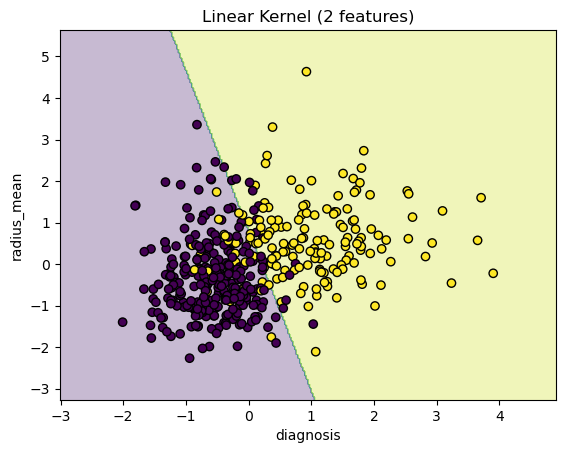

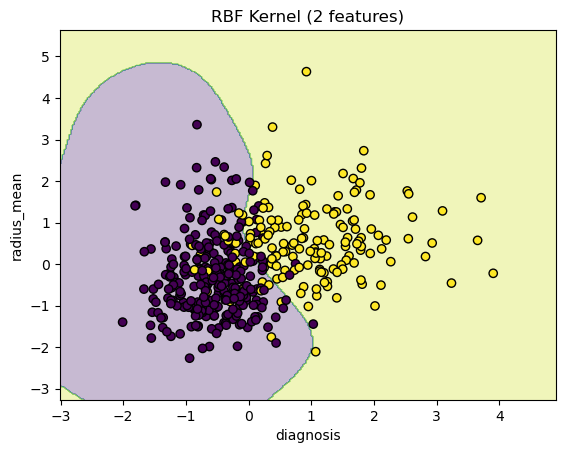

In [6]:
#Visualization in 2D (first two features)
X2 = X[:, :2]
X2_train, X2_test, y2_train, _ = train_test_split(X2, y, test_size=0.2, stratify=y, random_state=42)
scaler2d = StandardScaler()
X2_train_scaled = scaler2d.fit_transform(X2_train)

svm_lin2d = SVC(kernel="linear", C=1).fit(X2_train_scaled, y2_train)
svm_rbf2d = SVC(kernel="rbf", C=1, gamma="scale").fit(X2_train_scaled, y2_train)

def plot_boundary(model, Xs, ys, title):
    x0, x1 = Xs[:, 0], Xs[:, 1]
    xx, yy = np.meshgrid(
        np.linspace(x0.min()-1, x0.max()+1, 300),
        np.linspace(x1.min()-1, x1.max()+1, 300)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(Xs[:,0], Xs[:,1], c=ys, edgecolors='k')
    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.show()

plot_boundary(svm_lin2d, X2_train_scaled, y2_train, "Linear Kernel (2 features)")
plot_boundary(svm_rbf2d, X2_train_scaled, y2_train, "RBF Kernel (2 features)")


In [7]:
# Hyperparameter tuning using GridSearchCV + Pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf"))])
param_grid = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": [1, 0.1, 0.01, 0.001]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv)
grid.fit(X_train_raw, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)
best = grid.best_estimator_
print("Test accuracy:", best.score(X_test_raw, y_test))

Best params: {'svc__C': 10, 'svc__gamma': 0.01}
Best CV score: 0.9758241758241759
Test accuracy: 0.9824561403508771


In [8]:
cv_scores = cross_val_score(best, X, y, cv=cv)
print("CV scores:", cv_scores)
print("Mean CV accuracy: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))

CV scores: [1.         0.94736842 0.98245614 0.99122807 0.98230088]
Mean CV accuracy: 0.9807 ± 0.0179
